In [1]:
import re
import pandas as pd
from collections import defaultdict
import requests
from time import sleep
from pathlib import Path
import time
import json
import os
import numpy as np
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from catboost import Pool
from sklearn.metrics import mean_squared_error

def clean_name(name):
    s = str(name).strip()
    s = re.sub(
        r'\b(ПАО|МКПАО|АО|PJSC|пao|ао|ао.|3ао)\b',
        '',
        s,
        flags=re.IGNORECASE
    )
    s = re.sub(
        r'\b(акции\s*обыкн\.?|акц\.?\s*пр\.?|акц\.?\s*об\.?|преф\.?|-п|-ап|-ао|ап|ао)\b',
        '',
        s,
        flags=re.IGNORECASE
    )
    s = re.sub(r'\s{2,}', ' ', s)
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r'[.\s]+$', '', s)
    s = re.sub(
        r'^(["«“\'])(.+?)(["»”\'])$',
        r'\2',
        s
    )
    s = re.sub(r'[.\s]+$', '', s)
    s = re.sub(r'\s{2,}', ' ', s)
    s = re.sub(r'-\s*ао\s*$', '', s, flags=re.IGNORECASE)
    s = re.sub(r'\s*-\s*$', '', s)
    s = re.sub(r'^\s*(["«“\'])(.*?)(["»”\'])\s*$', r'\2', s)
    s = s.strip()
    if re.search(r'"', s) and not s.startswith('"') and not s.endswith('"'):
        s += '"'
    s = s.strip()        
    if re.search(r'«', s) and not s.startswith('«') and not s.endswith('»'):
        s += '»'    
    return s.strip()

def get_key_companies_from_moex():
    """
    Получает список ключевых компаний (первого уровня листинга) с MOEX
    """
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
    
    params = {
        'iss.meta': 'off',
        'securities.columns': 'SECID,SECNAME,SHORTNAME,LISTLEVEL',
        'marketdata.columns': 'LAST'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data['securities']['data'], 
                      columns=data['securities']['columns'])
    
    key_companies = df[df['LISTLEVEL'] == 1].copy()
    
    company_dict = {}
    for _, row in key_companies.iterrows():
        company_dict[row['SECID']] = {
            'name': row['SECNAME'],
            'short_name': row['SHORTNAME'],
            'cleaned_name': clean_name(row['SECNAME']),
            'cleaned_short_name': clean_name(row['SHORTNAME']),
            'ticker': row['SECID']
        }
    
    return company_dict, key_companies

company_dict, df_companies = get_key_companies_from_moex()
print(f"Найдено ключевых компаний: {len(company_dict)}")
print("\nСправочник компаний:")
for ticker, info in list(company_dict.items()):
    print(f"{ticker}: {info['name']} | {info['short_name']}")
    print(f"{info['cleaned_name']} | {info['cleaned_short_name']}")

Найдено ключевых компаний: 69

Справочник компаний:
AFKS: АФК "Система" ПАО ао | Система ао
АФК "Система" | Система
AFLT: Аэрофлот-росс.авиалин(ПАО)ао | Аэрофлот
Аэрофлот-росс.авиалин | Аэрофлот
ALRS: АЛРОСА ПАО ао | АЛРОСА ао
АЛРОСА | АЛРОСА
AQUA: ПАО ИНАРКТИКА | ИНАРКТИКА
ИНАРКТИКА | ИНАРКТИКА
ASTR: Группа Астра ао | iАстра ао
Группа Астра | iАстра
BELU: НоваБев Групп ПАО ао | НоваБев ао
НоваБев Групп | НоваБев
BSPB: ПАО "Банк "Санкт-Петербург" ао | БСП ао
Банк "Санкт-Петербург" | БСП
CBOM: "МКБ" ПАО ао | МКБ ао
МКБ | МКБ
CHMF: Северсталь (ПАО)ао | СевСт-ао
Северсталь | СевСт
CNRU: МКПАО "Циан" | Циан
Циан | Циан
DOMRF: ПАО ДОМ.РФ | ДОМ.РФ
ДОМ.РФ | ДОМ.РФ
ELFV: "ЭЛ5-Энерго" ПАО | ЭЛ5Энер ао
ЭЛ5-Энерго | ЭЛ5Энер
ENPG: МКПАО ЭН+ ГРУП ао | ЭН+ГРУП ао
ЭН+ ГРУП | ЭН+ГРУП
EUTR: ЕвроТранс ао | ЕвроТранс
ЕвроТранс | ЕвроТранс
FEES: "ФСК - Россети" ПАО | Россети
ФСК - Россети | Россети
FIXR: ПАО Фикс Прайс | Фикс Прайс
Фикс Прайс | Фикс Прайс
FLOT: Совкомфлот ао | Совкомфлот
Совкомфлот | Совк

In [2]:
def map_news_to_companies(df, company_dict):
    news_by_company = defaultdict(list)
    company_patterns = []
    for ticker, info in company_dict.items():
        cleaned_name = re.escape(info['cleaned_name'])
        cleaned_short = re.escape(info['cleaned_short_name'])
        company_patterns.append((ticker, cleaned_name))
        company_patterns.append((ticker, cleaned_short))
    for idx, row in df.iterrows():
        body = str(row['body'])
        for ticker, pattern in company_patterns:
            if re.search(r'\b' + pattern + r'\b', body, flags=re.IGNORECASE):
                news_by_company[ticker].append({
                    'title': row['title'],
                    'body': row['body'],
                    'date': row['date'],
                    'time': row['time'],
                    'tags': row['tags'],
                    'source': row['source']
                })

    return news_by_company

In [3]:
df = pd.read_parquet("RussianFinancialNews/news_collection.parquet")
news_by_company = map_news_to_companies(df, company_dict)
for ticker, news_list in news_by_company.items():
    print(ticker, len(news_list))

GAZP 5392
LSRG 177
PIKK 315
SMLT 666
FLOT 412
LKOH 1411
MTSS 803
ROSN 1287
TATN 318
TRNFP 244
CHMF 398
HEAD 106
MAGN 618
NLMK 1274
YDEX 1746
NVTK 934
RAGR 449
AFKS 536
RTKM 234
RTKMP 234
SGZH 408
MOEX 9654
PLZL 638
VTBR 1354
AFLT 365
MTLR 488
MTLRP 488
RUAL 240
HYDR 1018
MDMG 69
SBER 448
SBERP 448
ASTR 54
ALRS 1278
MVID 354
BELU 72
LEAS 64
RENI 676
CNRU 356
AQUA 210
IRAO 212
SVCB 292
OZON 98
EUTR 118
CBOM 122
MBNK 74
VSEH 26
PHOR 882
ELFV 70
FEES 462
UPRO 714
VKCO 86
SELG 240
TGKA 210
POSI 67
SFIN 148
LENT 202
MSNG 91
DOMRF 182
OZPH 21
T 12
X5 9
GEMC 16
BSPB 17
ENPG 7


In [4]:
def split_sentences(text: str):
    text = re.sub(r"\s+", " ", text)
    return [s.strip() for s in re.split(r"(?<=[.!?])\s+", text) if len(s.strip()) > 5]

def sentence_mentions_company(sentence: str, company_info: dict):
    s = sentence.lower()
    return (
        company_info["cleaned_name"] in s
        or company_info["cleaned_short_name"] in s
        or company_info["ticker"].lower() in s
    )

def deepseek_local(prompt, model="deepseek-r1:8b", timeout=120):
    r = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": model,
            "prompt": prompt,
            "stream": False
        },
        timeout=timeout
    )
    r.raise_for_status()
    return r.json()["response"]

def deepseek_absa_sentence(sentence, ticker, company_name, model="deepseek-r1:8b"):
    prompt = f"""
Ты — финансовый аналитик.

Определи сентимент ТОЛЬКО по отношению к компании {company_name} ({ticker})
в следующем предложении.

Верни ТОЛЬКО JSON без текста:

{{
  "sentiment": -1 | 0 | 1,
  "confidence": число от 0 до 1
}}

Предложение:
\"{sentence}\"
"""
    response = deepseek_local(prompt, model=model)
    try:
        json_text = re.search(r"\{.*\}", response, re.S).group()
        result = json.loads(json_text)
        if "sentiment" not in result or "confidence" not in result:
            return {"sentiment": 0, "confidence": 0.0}
        return result
    except Exception:
        return {"sentiment": 0, "confidence": 0.0}

def sentences_to_daily_df(results):
    POS_TH = 0.15
    NEG_TH = -0.15
    rows = []
    for ticker, data in results.items():
        if isinstance(data, dict) and "sentences" in data:
            sentences = data["sentences"]
        else:
            sentences = data
        for s in sentences:
            rows.append({
                "ticker": ticker,
                "date": pd.to_datetime(s["date"]),
                "sentiment": s["sentiment"],
                "confidence": s["confidence"]
            })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    daily = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum")
          )
    )
    daily["sentiment_score"] = daily["weighted_sum"] / daily["conf_sum"]
    daily = daily.drop(columns=["weighted_sum", "conf_sum"])
    daily["sentiment_sign"] = daily["sentiment_score"].apply(
        lambda x: 1 if x > POS_TH else (-1 if x < NEG_TH else 0)
    )
    return daily

In [5]:
def load_absa_cache(path="absa_results.json"):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            print(f"ABSA cache loaded: {path}")
            return json.load(f)
    print("ABSA cache not found — starting fresh")
    return {}

def save_absa_cache(results, path="absa_results.json"):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"ABSA cache saved → {path}")

In [6]:
def run_deepseek_absa(
    news_by_company: dict,
    company_dict: dict,
    model="deepseek-r1:8b",
    cache_path="absa_results.json"
):
    results = load_absa_cache(cache_path)
    for ticker, news_list in news_by_company.items():
        company_info = company_dict[ticker]
        print(f"\n=== {ticker} | {company_info['name']} ===")
        if ticker not in results:
            results[ticker] = []
        existing_keys = {
            (r["date"], r["sentence"]) for r in results[ticker]
        }
        total_news = len(news_list)
        for i, news in enumerate(news_list, 1):
            print(f"[{ticker}] news {i}/{total_news}")
            sentences = split_sentences(news["body"])
            for sent in sentences:
                key = (news["date"], sent)
                if key in existing_keys:
                    continue
                if not sentence_mentions_company(sent, company_info):
                    continue
                absa = deepseek_absa_sentence(
                    sentence=sent,
                    ticker=ticker,
                    company_name=company_info["name"],
                    model=model
                )
                results[ticker].append({
                    "date": news["date"],
                    "time": news["time"],
                    "source": news["source"],
                    "sentence": sent,
                    "sentiment": absa["sentiment"],
                    "confidence": round(absa["confidence"], 3)
                })
                existing_keys.add(key)
        save_absa_cache(results, cache_path)
    return results


In [7]:
absa_result = run_deepseek_absa(news_by_company, company_dict)
with open("absa_results.json", "w", encoding="utf-8") as f:
    json.dump(absa_result, f, ensure_ascii=False, indent=2)
agg_results = sentences_to_daily_df(absa_result)

ABSA cache loaded: absa_results.json

=== GAZP | "Газпром" (ПАО) ао ===
[GAZP] news 1/5392
[GAZP] news 2/5392
[GAZP] news 3/5392
[GAZP] news 4/5392
[GAZP] news 5/5392
[GAZP] news 6/5392
[GAZP] news 7/5392
[GAZP] news 8/5392
[GAZP] news 9/5392
[GAZP] news 10/5392
[GAZP] news 11/5392
[GAZP] news 12/5392
[GAZP] news 13/5392
[GAZP] news 14/5392
[GAZP] news 15/5392
[GAZP] news 16/5392
[GAZP] news 17/5392
[GAZP] news 18/5392
[GAZP] news 19/5392
[GAZP] news 20/5392
[GAZP] news 21/5392
[GAZP] news 22/5392
[GAZP] news 23/5392
[GAZP] news 24/5392
[GAZP] news 25/5392
[GAZP] news 26/5392
[GAZP] news 27/5392
[GAZP] news 28/5392
[GAZP] news 29/5392
[GAZP] news 30/5392
[GAZP] news 31/5392
[GAZP] news 32/5392
[GAZP] news 33/5392
[GAZP] news 34/5392
[GAZP] news 35/5392
[GAZP] news 36/5392
[GAZP] news 37/5392
[GAZP] news 38/5392
[GAZP] news 39/5392
[GAZP] news 40/5392
[GAZP] news 41/5392
[GAZP] news 42/5392
[GAZP] news 43/5392
[GAZP] news 44/5392
[GAZP] news 45/5392
[GAZP] news 46/5392
[GAZP] news 47/53

In [8]:
print(agg_results)

     ticker       date  sentiment_score  sentiment_sign
0      AFKS 2022-08-12         0.000000               0
1      AFKS 2022-11-28         0.000000               0
2      AFKS 2022-12-15         0.000000               0
3      AFKS 2023-03-14         0.000000               0
4      AFKS 2023-03-15         0.000000               0
...     ...        ...              ...             ...
1950   YDEX 2024-09-09         1.000000               1
1951   YDEX 2024-09-13         1.000000               1
1952   YDEX 2024-09-23         0.142857               0
1953   YDEX 2024-10-29         0.612903               1
1954   YDEX 2024-11-15         0.000000               0

[1955 rows x 4 columns]


In [9]:
def deduplicate_sentences(df: pd.DataFrame) -> pd.DataFrame:
    """
    Убирает дубликаты одинаковых предложений,
    агрегируя sentiment по confidence
    """
    grouped = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date", "sentence"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum"),
              confidence=("confidence", "mean"),
              source=("source", "first"),
              time=("time", "first")
          )
    )
    grouped["sentiment_score"] = grouped["weighted_sum"] / grouped["conf_sum"]
    grouped["sentiment"] = grouped["sentiment_score"].apply(
        lambda x: 1 if x > 0.15 else (-1 if x < -0.15 else 0)
    )
    return grouped.drop(columns=["weighted_sum", "conf_sum"])

In [10]:
def sentences_to_df(results: dict) -> pd.DataFrame:
    """
    Преобразует результаты ABSA в DataFrame по предложениям
    """
    rows = []
    for ticker, data in results.items():
        if isinstance(data, dict) and "sentences" in data:
            sentences = data["sentences"]
        else:
            sentences = data
        for s in sentences:
            rows.append({
                "ticker": ticker,
                "date": pd.to_datetime(s["date"]),
                "time": s.get("time"),
                "source": s.get("source"),
                "sentence": s["sentence"],
                "sentiment": s["sentiment"],
                "confidence": s["confidence"]
            })
    return pd.DataFrame(rows)


In [11]:
def sentences_to_daily_df_from_df(df: pd.DataFrame) -> pd.DataFrame:
    POS_TH = 0.15
    NEG_TH = -0.15

    if df.empty:
        return df

    daily = (
        df.assign(weighted=df.sentiment * df.confidence)
          .groupby(["ticker", "date"], as_index=False)
          .agg(
              weighted_sum=("weighted", "sum"),
              conf_sum=("confidence", "sum"),
              n_sentences=("sentence", "count")
          )
    )
    daily["sentiment_score"] = daily["weighted_sum"] / daily["conf_sum"]
    daily["sentiment_sign"] = daily["sentiment_score"].apply(
        lambda x: 1 if x > POS_TH else (-1 if x < NEG_TH else 0)
    )
    return daily.drop(columns=["weighted_sum", "conf_sum"])

In [12]:
df_sent = sentences_to_df(absa_result)
df_sent = deduplicate_sentences(df_sent)
daily = sentences_to_daily_df_from_df(df_sent)

In [13]:
print(daily)

     ticker       date  n_sentences  sentiment_score  sentiment_sign
0      AFKS 2022-08-12            1         0.000000               0
1      AFKS 2022-11-28            1         0.000000               0
2      AFKS 2022-12-15            1         0.000000               0
3      AFKS 2023-03-14            1         0.000000               0
4      AFKS 2023-03-15            2         0.000000               0
...     ...        ...          ...              ...             ...
1950   YDEX 2024-09-09            1         1.000000               1
1951   YDEX 2024-09-13            1         1.000000               1
1952   YDEX 2024-09-23            1         0.000000               0
1953   YDEX 2024-10-29            2         0.612903               1
1954   YDEX 2024-11-15            1         0.000000               0

[1955 rows x 5 columns]


In [14]:
ticker_news_count = (
    daily.groupby("ticker")["n_sentences"]
         .sum()
         .reset_index(name="total_news")
)
ticker_news_count.sort_values("total_news", ascending=False).head(20)
good_tickers = ticker_news_count.loc[
    ticker_news_count["total_news"] > 200,
    "ticker"
]
daily_filtered = daily[daily["ticker"].isin(good_tickers)].reset_index(drop=True)

In [15]:
print(daily_filtered)

    ticker       date  n_sentences  sentiment_score  sentiment_sign
0     LKOH 2022-06-16            2         0.583333               1
1     LKOH 2022-06-17            1         1.000000               1
2     LKOH 2022-07-13            4         0.890909               1
3     LKOH 2022-07-22            6         0.926380               1
4     LKOH 2022-07-26            5         0.891892               1
..     ...        ...          ...              ...             ...
271   SMLT 2024-11-22            2         0.666667               1
272   SMLT 2024-11-29            3        -1.000000              -1
273   SMLT 2024-12-04            1         1.000000               1
274   SMLT 2024-12-12            1         0.000000               0
275   SMLT 2024-12-13            1        -1.000000              -1

[276 rows x 5 columns]


In [16]:
print("Tickers kept:", daily_filtered["ticker"].nunique())
print("Total daily rows:", len(daily_filtered))

Tickers kept: 2
Total daily rows: 276


In [17]:
news_date_range = (
    daily_filtered
        .groupby("ticker")["date"]
        .agg(
            news_start="min",
            news_end="max",
            n_days="nunique"
        )
        .reset_index()
)

In [18]:
news_date_range.sort_values("news_start")

,ticker,news_start,news_end,n_days
0,LKOH,2022-06-16,2024-12-13,125
1,SMLT,2022-06-17,2024-12-13,151


In [19]:
def load_moex_prices(
    ticker: str,
    start_date: str,
    end_date: str,
    board: str = "TQBR",
    market: str = "shares",
    engine: str = "stock",
    sleep_sec: float = 0.2
):
    url = (
        f"https://iss.moex.com/iss/history/engines/{engine}/"
        f"markets/{market}/boards/{board}/securities/{ticker}.json"
    )

    all_rows = []
    start = 0

    while True:
        params = {
            "from": start_date,
            "till": end_date,
            "start": start,
            "iss.meta": "off",
            "iss.only": "history",
            "history.columns": "TRADEDATE,OPEN,HIGH,LOW,CLOSE,VOLUME"
        }

        r = requests.get(url, params=params)
        data = r.json()["history"]

        if not data["data"]:
            break

        cols = data["columns"]
        rows = data["data"]

        df_part = pd.DataFrame(rows, columns=cols)
        all_rows.append(df_part)

        start += len(rows)
        sleep(sleep_sec)

    if not all_rows:
        return pd.DataFrame()

    df = pd.concat(all_rows, ignore_index=True)
    df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
    df["ticker"] = ticker

    return df


In [20]:
all_prices = []

for _, row in news_date_range.iterrows():
    ticker = row["ticker"]
    start_date = row["news_start"].strftime("%Y-%m-%d")
    end_date = row["news_end"].strftime("%Y-%m-%d")

    print(f"{ticker}: {start_date} → {end_date}")

    df_prices = load_moex_prices(
        ticker=ticker,
        start_date=start_date,
        end_date=end_date
    )

    if not df_prices.empty:
        all_prices.append(df_prices)


LKOH: 2022-06-16 → 2024-12-13
SMLT: 2022-06-17 → 2024-12-13


In [21]:
prices_df = pd.concat(all_prices, ignore_index=True)
prices_df = prices_df.rename(columns={
    "TRADEDATE": "date",
    "OPEN": "open",
    "HIGH": "high",
    "LOW": "low",
    "CLOSE": "close",
    "VOLUME": "volume"
})
prices_df = prices_df.sort_values(["ticker", "date"]).reset_index(drop=True)

In [22]:
prices_df.head()

,date,open,high,low,close,volume,ticker
0,2022-06-16,4116.5,4300.0,4105.0,4261.5,1089748,LKOH
1,2022-06-17,4289.5,4326.0,4137.0,4182.0,499050,LKOH
2,2022-06-20,4202.0,4245.0,4128.0,4209.5,461006,LKOH
3,2022-06-21,4239.0,4279.5,4031.5,4045.0,590551,LKOH
4,2022-06-22,3990.0,4179.5,3932.5,4139.0,745924,LKOH


In [23]:
prices_df.to_parquet("moex_prices.parquet", index=False)

In [24]:
df = prices_df.merge(
    daily_filtered,
    on=["ticker", "date"],
    how="left"
)
df["sentiment_score"] = df["sentiment_score"].fillna(0.0)
df["sentiment_sign"] = df["sentiment_sign"].fillna(0)

In [25]:
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

In [26]:
SENT_LAGS = [1, 2, 3, 5]
for lag in SENT_LAGS:
    df[f"sentiment_score_lag{lag}"] = (
        df.groupby("ticker")["sentiment_score"].shift(lag)
    )
    df[f"sentiment_sign_lag{lag}"] = (
        df.groupby("ticker")["sentiment_sign"].shift(lag)
    )

In [27]:
PRICE_LAGS = [1, 2, 5]
for lag in PRICE_LAGS:
    df[f"close_lag{lag}"] = df.groupby("ticker")["close"].shift(lag)
    df[f"volume_lag{lag}"] = df.groupby("ticker")["volume"].shift(lag)
df["log_return"] = (
    np.log(df["close"]) - np.log(df.groupby("ticker")["close"].shift(1))
)

In [28]:
ROLLS = [3, 5, 10]

for w in ROLLS:
    df[f"sentiment_roll_mean_{w}"] = (
        df.groupby("ticker")["sentiment_score"]
          .rolling(w)
          .mean()
          .reset_index(level=0, drop=True)
    )

    df[f"return_roll_std_{w}"] = (
        df.groupby("ticker")["log_return"]
          .rolling(w)
          .std()
          .reset_index(level=0, drop=True)
    )


In [29]:
df["target_close_t1"] = df.groupby("ticker")["close"].shift(-1)
df_model = df.dropna().reset_index(drop=True)
FEATURES = [
    "sentiment_score",
    "sentiment_sign",
    "log_return",
    "volume",
    *[f"sentiment_score_lag{l}" for l in SENT_LAGS],
    *[f"sentiment_sign_lag{l}" for l in SENT_LAGS],
    *[f"close_lag{l}" for l in PRICE_LAGS],
    *[f"volume_lag{l}" for l in PRICE_LAGS],
    *[f"sentiment_roll_mean_{w}" for w in ROLLS],
    *[f"return_roll_std_{w}" for w in ROLLS],
]
TARGET = "target_close_t1"

In [30]:
CAT_FEATURES = ["ticker"]
X = df_model[FEATURES + CAT_FEATURES]
y = df_model[TARGET]

In [31]:
split_date = "2024-01-01"
train_idx = df_model["date"] < split_date
test_idx = df_model["date"] >= split_date
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [32]:
model = CatBoostRegressor(
    iterations=1000,
    depth=5,
    learning_rate=0.05,
    loss_function="RMSE",
    eval_metric="RMSE",
    l2_leaf_reg=10,
    cat_features=CAT_FEATURES,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 1365.3286978	test: 2186.8173727	best: 2186.8173727 (0)	total: 141ms	remaining: 2m 20s
100:	learn: 165.6712643	test: 788.5549848	best: 788.5549848 (100)	total: 216ms	remaining: 1.92s
200:	learn: 90.4953279	test: 724.5077352	best: 724.5077352 (200)	total: 277ms	remaining: 1.1s
300:	learn: 72.2630938	test: 705.2953811	best: 705.2953811 (300)	total: 341ms	remaining: 791ms
400:	learn: 58.5231613	test: 690.9504381	best: 690.9504381 (400)	total: 406ms	remaining: 607ms
500:	learn: 44.8125739	test: 682.7952804	best: 682.7952804 (500)	total: 470ms	remaining: 468ms
600:	learn: 35.6167050	test: 677.0484671	best: 677.0484671 (600)	total: 533ms	remaining: 354ms
700:	learn: 28.5923691	test: 673.2566257	best: 673.2566257 (700)	total: 598ms	remaining: 255ms
800:	learn: 23.2378847	test: 671.5876118	best: 671.5876118 (800)	total: 659ms	remaining: 164ms
900:	learn: 18.9481400	test: 669.8959287	best: 669.8959287 (900)	total: 719ms	remaining: 79ms
999:	learn: 15.4666585	test: 668.7430346	best: 668

In [33]:
rmse_baseline = np.sqrt(mean_squared_error(y_test, [y_train.mean()] * len(y_test)))
rmse_baseline

2235.1366219186634

In [34]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,close_lag5,33.712943
1,close_lag1,27.642402
2,close_lag2,21.004165
3,ticker,5.340786
4,volume_lag2,1.653661
5,return_roll_std_5,1.195272
6,sentiment_roll_mean_10,1.151135
7,volume_lag5,0.998277
8,return_roll_std_10,0.866843
9,return_roll_std_3,0.866584


In [35]:
model.save_model("catboost_rmse_669.cbm")

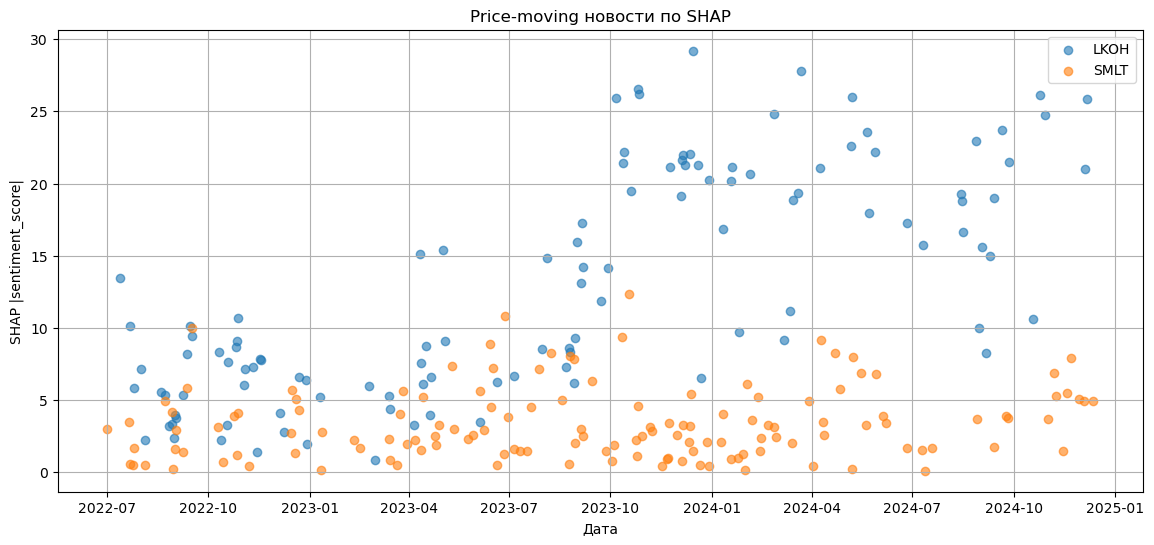

In [36]:
cat_features = ["ticker"]
data_pool = Pool(data=X, label=y, cat_features=cat_features)
shap_values = model.get_feature_importance(
    data=data_pool,
    type="ShapValues"
)
shap_values_only = shap_values[:, :-1]
shap_df = pd.DataFrame(shap_values_only, columns=X.columns)
shap_df["date"] = df_model["date"].values
shap_df["ticker"] = df_model["ticker"].values
shap_df["y_true"] = y.values
shap_df["abs_sentiment_shap"] = np.abs(shap_df["sentiment_score"])
PRICE_SHAP_THRESHOLD = 0.05
price_moving_df = shap_df[shap_df["abs_sentiment_shap"] > PRICE_SHAP_THRESHOLD]
plt.figure(figsize=(14,6))
for ticker in price_moving_df["ticker"].unique():
    df_t = price_moving_df[price_moving_df["ticker"] == ticker]
    plt.scatter(df_t["date"], df_t["abs_sentiment_shap"], label=ticker, alpha=0.6)
plt.xlabel("Дата")
plt.ylabel("SHAP |sentiment_score|")
plt.title("Price-moving новости по SHAP")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
df_model.head()

,date,open,high,low,close,volume,ticker,n_sentences,sentiment_score,sentiment_sign,...,close_lag5,volume_lag5,log_return,sentiment_roll_mean_3,return_roll_std_3,sentiment_roll_mean_5,return_roll_std_5,sentiment_roll_mean_10,return_roll_std_10,target_close_t1
0,2022-07-13,3757.0,3767.0,3619.0,3645.5,585484,LKOH,4.0,0.890909,1.0,...,3962.0,603617.0,-0.028796,0.296970,0.006566,0.178182,0.010960,0.089091,0.015826,3608.0
1,2022-07-22,3552.0,3688.0,3551.0,3688.0,575224,LKOH,6.0,0.926380,1.0,...,3709.0,461637.0,0.041099,0.308793,0.028768,0.185276,0.023981,0.181729,0.022521,3669.0
2,2022-07-26,3694.0,3825.0,3675.5,3825.0,544414,LKOH,5.0,0.891892,1.0,...,3600.0,306816.0,0.041639,0.606091,0.026868,0.363654,0.026810,0.270918,0.025229,3847.5
3,2022-08-01,3883.0,4030.0,3825.5,3931.0,1010266,LKOH,2.0,1.000000,1.0,...,3669.0,369717.0,0.013832,0.333333,0.009965,0.378378,0.017095,0.281827,0.019946,3823.0
4,2022-08-05,3720.0,3746.0,3659.5,3679.5,379687,LKOH,1.0,0.000000,0.0,...,3877.0,275990.0,-0.010947,0.000000,0.007523,0.200000,0.015983,0.189189,0.019787,3720.0


In [38]:
def plot_price_moving_shap(
    model,
    df_model,
    df_sent,
    cat_features=["ticker"],
    shap_threshold=0.05,
    top_n=20
):
    """
    Визуализация price-moving новостей по SHAP для CatBoost.

    Args:
        model: обученная CatBoost модель
        df_model: DataFrame с фичами и целевой переменной (target_close_t1)
        df_sent: DataFrame с предложениями (ticker, date, sentence, sentiment_score)
        cat_features: список категориальных колонок
        shap_threshold: минимальное значение абсолютного вклада sentiment, чтобы считать news price-moving
        top_n: количество топ-дней для отображения на графике
    Returns:
        price_moving_df: DataFrame только с price-moving новостями и SHAP
    """
    X = df_model.drop(columns=["target_close_t1"])
    y = df_model["target_close_t1"]
    pool = Pool(data=X, label=y, cat_features=cat_features)
    shap_values = model.get_feature_importance(pool, type="ShapValues")
    shap_values_only = shap_values[:, :-1]
    shap_df = pd.DataFrame(shap_values_only, columns=X.columns)
    shap_df["date"] = df_model["date"].values
    shap_df["ticker"] = df_model["ticker"].values
    shap_df["y_true"] = y.values
    shap_df["abs_sentiment_shap"] = shap_df["sentiment_score"].abs()
    price_moving_df = shap_df[shap_df["abs_sentiment_shap"] > shap_threshold].copy()
    df_sent_daily = df_sent.groupby(["ticker", "date"]).agg({
        "sentence": lambda x: " | ".join(x),
        "sentiment_score": "mean"
    }).reset_index()
    price_moving_df = price_moving_df.merge(
        df_sent_daily,
        on=["ticker", "date"],
        how="left"
    )
    plt.figure(figsize=(14,6))
    for ticker in price_moving_df["ticker"].unique():
        df_plot = price_moving_df[price_moving_df["ticker"] == ticker].sort_values("date")
        plt.plot(df_plot["date"], df_plot["abs_sentiment_shap"], marker='o', label=ticker)
    plt.title("Price-moving news (SHAP) по времени")
    plt.xlabel("Дата")
    plt.ylabel("|SHAP вклад sentiment|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    top_news = price_moving_df.sort_values("abs_sentiment_shap", ascending=False).head(top_n)
    print("Топовые price-moving новости:")
    for idx, row in top_news.iterrows():
        print(f"{row['date']} | {row['ticker']} | SHAP={row['abs_sentiment_shap']:.3f}")
        print(f"→ {row['sentence']}\n")
    return price_moving_df

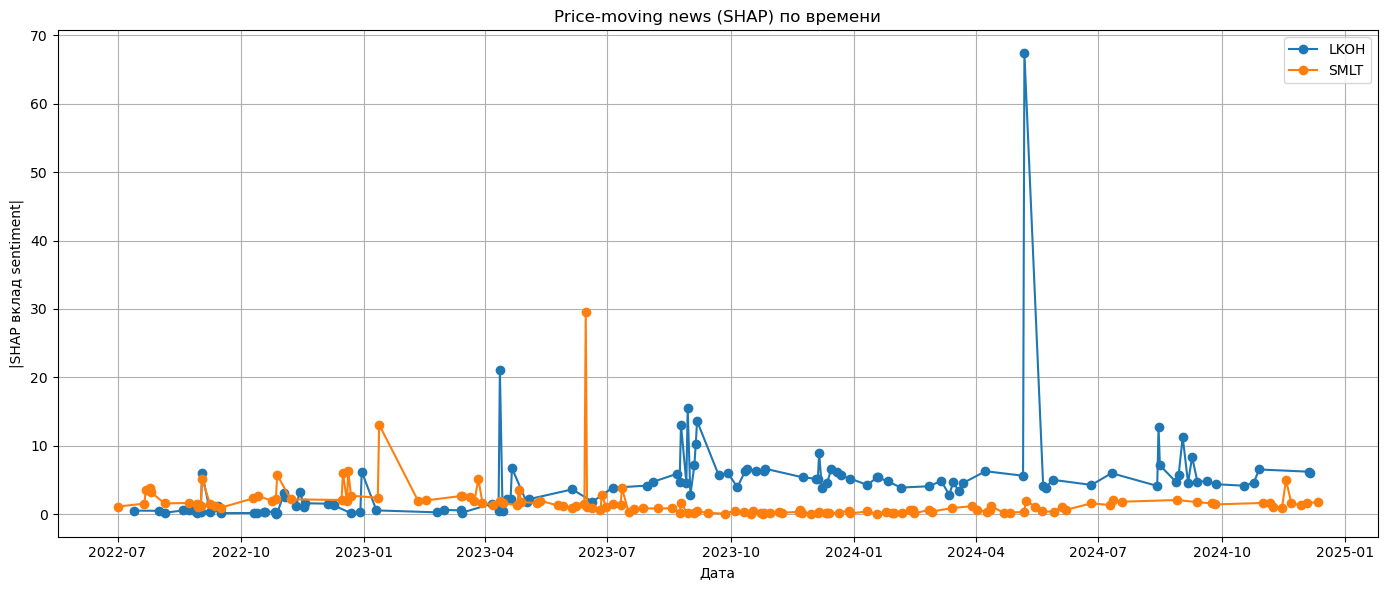

Топовые price-moving новости:
2024-05-07 00:00:00 | LKOH | SHAP=67.365
→ (2) Лукойл (LKOH): дивгэп.

2023-06-15 00:00:00 | SMLT | SHAP=29.534
→ " Источники РДВ на ПМЭФ послушали выступление СЕО Самолет (SMLT) Антона Елистратова.

2023-04-12 00:00:00 | LKOH | SHAP=21.134
→ "️️️ Подтверждено: Лукойл (LKOH) продаёт НПЗ на Сицилии. | Лукойл (LKOH) может стать самой дивидендной нефтяной акцией года.

2023-08-30 00:00:00 | LKOH | SHAP=15.495
→ Лукойл (LKOH) 4.77 5.

2023-09-06 00:00:00 | LKOH | SHAP=13.601
→ #аналитика Лукойл (LKOH). | В Топ рейтинга попадали четыре компании: Лукойл (LKOH), Самолет (SMLT), Группа Позитив (POSI) и Whoosh (WUSH).

2023-01-12 00:00:00 | SMLT | SHAP=13.079
→ "Самолет (SMLT): справедливая стоимость 4155 рублей на акцию, потенциал роста +63%. | $$$ Фундаментальная $$$ • ГК Самолет (SMLT) — одна из крупнейших федеральных корпораций в сфере девелопмента и PropTech (property technology, технологии в области недвижимости).

2023-08-25 00:00:00 | LKOH | SHAP=13.064
→ "

In [39]:
price_moving_df = plot_price_moving_shap(
    model=model,
    df_model=df_model,
    df_sent=df_sent,
    cat_features=["ticker"],
    shap_threshold=0.05,
    top_n=15
)